# Earnings Call Modeling

## Objectives  
**1. Topic Modeling** - Use unsupervised learning to identify topics discussed on earnings calls.  The topics for questions and answers will be derived seperatly but have been found to share common themes.  
**2. Stock Price Modeling** - Using the question and answer topics for each call, train a supervised learning model to predict stock movements following an earnings call.  
**3. Tableau Dashboard Export** - Structure and generate the topic analysis for consumption by a Tableau dashboard for enhanced visualization and analysis.

<a id='home'></a>
## Contents

**Setup**  
1. [Imports](#id)  
2. [Data Loading](#2)  
3. [Text Modeling Functions](#3)  

**Objective 1:  Topic Modeling**  
4. [Questions Only](#4)  
5. [Answers Only](#5)  

**Objective 2:  Stock Price Modeling**  
6. [1 Month Stock Price Change](#6)  
7. [1 Month Stock Volatility](#7)  

**Objective 3:  Tableau Dashboard Export**  
8. [Company Sectors by Topics](#8)  
9. [Earning Call by Topics](#9)

<a id='1'></a>

---

## Imports

In [1]:
import requests
import pickle
import re
import string
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer#, CountVectorizer
from sklearn.decomposition import NMF

from nltk.tokenize import word_tokenize
from nltk.stem.lancaster import LancasterStemmer
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords

# from gensim import models, matutils

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import f1_score, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

random_state = 2019

In [2]:
# Assign output directory for Tableau data
out_path = 'output/'

<a id='2'></a>
# Load Pickle Data

In [3]:
with open('pickle_data/all_text_update.pkl', 'rb') as picklefile:
    all_text = pickle.load(picklefile)

In [4]:
with open('pickle_data/prices.pkl', 'rb') as picklefile: 
    price_df = pickle.load(picklefile)

price_df.drop(price_df[price_df['call_id'] == '439.3'].index,inplace=True)

<a id='3'></a>
# Text Modeling Functions

In [5]:
def doc_only_QA(documents):
    '''
    Filter all transcripts for only Q&A section and remove Operator
    '''
    text_ids = []
    new_text = []
    call_id = ''
    
    for d in documents:
        if d[1] == 'Q and A' and d[2] != 'Operator':
            if call_id == d[0]:
                new_text[-1] += ' ' + d[3] 
            else:
                call_id = d[0]
                text_ids.append(call_id)
                new_text.append(d[3])
                
    return text_ids, new_text


def doc_only_Qs(documents):
    '''
    Filter all transcripts for only questions in Q&A and remove Operator
    '''
    text_ids = []
    new_text = []
    call_id = ''
    
    for d in documents:
        if d[1] == 'Q and A' and d[2] != 'Operator' and d[4] == 'external':
            if call_id == d[0]:
                new_text[-1] += ' ' + d[3] 
            else:
                call_id = d[0]
                text_ids.append(call_id)
                new_text.append(d[3])
                
    return text_ids, new_text


def doc_only_As(documents):
    '''
    Filter all transcripts for only answers in Q&A and remove Operator
    '''
    text_ids = []
    new_text = []
    call_id = ''
    
    for d in documents:
        if d[1] == 'Q and A' and d[2] != 'Operator' and d[4] == 'internal':
            if call_id == d[0]:
                new_text[-1] += ' ' + d[3] 
            else:
                call_id = d[0]
                text_ids.append(call_id)
                new_text.append(d[3])
                
    return text_ids, new_text

In [6]:
def clean_string(text):
    clean_text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)

    # All lowercase
    clean_text = clean_text.lower()

    # Remove q1 - q4 mentions
    clean_text = re.sub('\w*q\d\w*', ' ', clean_text)

    # Remove numbers
    clean_text = re.sub('\w*\d\w*', ' ', clean_text)
    
    # Tokenize
    clean_text = word_tokenize(clean_text)

    ## Stemming
    # tokenized = []
    # stemmer = LancasterStemmer() 
    # tokenized.append([stemmer.stem(w) for w in clean_text])
    
    # Lemmatization
    tokenized = []
    lemmatizer = WordNetLemmatizer() 
    tokenized = [lemmatizer.lemmatize(w) for w in clean_text]
    
    return tokenized

In [7]:
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [8]:
def nmf_and_output(vectorizer, docs, catagories, top_words=10):
    doc_words = vectorizer.fit_transform(docs)
    nmf_model = NMF(catagories)
    doc_topic = nmf_model.fit_transform(doc_words)
    display_topics(nmf_model, vectorizer.get_feature_names(), top_words)
    return doc_topic

In [17]:
def create_topic_df(topic_maps,ids,prefix,pct=False):
    cols = [prefix + '_topic_%.i' % (i+1) for i in range(topic_maps.shape[1])]
    df = pd.DataFrame(topic_maps,columns = cols)
    if pct == True:
        df = df.div(df.sum(axis=1), axis=0)
    df['call_id'] = ids
    
    return df, cols

<a id='4'></a>
# Topic Model:  Questions Only
TF-IDF + NMF

In [9]:
# Create list of text and IDs for only questions
ids_Q_only, text_Q_only = doc_only_Qs(all_text)

# Limit text to only what we have prices for
text_Q_only = [j for i,j in zip(ids_Q_only,text_Q_only) if price_df['call_id'].eq(i).sum() == True]
ids_Q_only = [i for i in ids_Q_only if price_df['call_id'].eq(i).sum() == True]

print ('IDs: ',len(ids_Q_only))
print ('Text:',len(text_Q_only))

IDs:  9746
Text: 9746


In [10]:
# Define stop words - Questions
q_words = ['growth','thanks','okay','kind','guy','nim','morning','yes','got','gotcha','luck',
           'please','bit','color','helpful','talk','taking','hey','afternoon','ok','people',
           'guess','right','last','etc','really','well','get','yeah','say','thing','sort',
           'wanted','know','follow','curious','wondering','seeing','thinking','hi','give',
           'would','great','appreciate','motley','fool','analystokay','transcript','officeryeah']

q_word_fragments = ['doe','ha','wa','r','k','fy','na','sg','gon']

q_stop_words = list(stopwords.words('english')) + q_words + q_word_fragments

In [11]:
catagories = 23

# Setup TFIDF Vectorizer
tfidf_q = TfidfVectorizer(stop_words = q_stop_words,tokenizer=clean_string,max_df=0.9,min_df=5)

print ('Questions Only')
questions_doc_topics = nmf_and_output(vectorizer=tfidf_q,docs=text_Q_only,catagories=catagories,top_words=10)


Questions Only

Topic  0
business, revenue, client, little, organic, acquisition, service, segment, side, term

Topic  1
loan, deposit, expense, credit, rate, bank, yield, mortgage, portfolio, fed

Topic  2
patient, study, data, trial, phase, dose, fda, clinical, therapy, program

Topic  3
lease, rent, tenant, asset, property, leasing, occupancy, noi, development, disposition

Topic  4
store, comp, traffic, sale, delivery, category, new, opening, best, merchandise

Topic  5
product, customer, new, sale, market, term, congrats, force, little, opportunity

Topic  6
rig, oil, production, cash, flow, free, basin, delaware, drilling, permian

Topic  7
price, volume, pricing, cost, market, increase, little, demand, inflation, raw

Topic  8
loss, ratio, auto, reinsurance, cat, commercial, premium, reserve, rate, book

Topic  9
million, cash, ebitda, flow, free, guidance, cost, number, capex, revenue

Topic  10
chief, executive, president, vice, financial, officer, chairman, research, article,

In [18]:
# Create Questions Topic Maps
q_topics, q_cols = create_topic_df(questions_doc_topics, ids_Q_only, prefix='q', pct=True)
price_df = price_df.merge(q_topics,on='call_id',how='inner')
q_topics = q_topics.merge(price_df[['call_id','sector']],on='call_id',how='inner')
q_topics = q_topics.groupby('sector').agg('mean')

<a id='5'></a>
# Topic Model:  Answers Only
TF-IDF + NMF

In [12]:
# Create list of text and IDs for only answers
ids_A_only, text_A_only = doc_only_As(all_text)

# Limit text to only dates we have prices for
text_A_only = [j for i,j in zip(ids_A_only,text_A_only) if price_df['call_id'].eq(i).sum() == True]
ids_A_only = [i for i in ids_A_only if price_df['call_id'].eq(i).sum() == True]

print ('IDs: ',len(ids_A_only))
print ('Text:',len(text_A_only))

IDs:  9708
Text: 9708


In [13]:
# Define stop words - Answers
a_words = ['thank','thanks','morning','thing','kind','like','mean','got','know','bit','yes',
           'people', 'want', 'say', 'go', 'sort', 'way', 'make', 'pretty','yeah','hey']

a_word_fragments = ['doe','ha','wa','r','k','fy','na','cd','gon']

a_stop_words = list(stopwords.words('english')) + a_words + a_word_fragments

In [14]:
catagories = 20

# Setup TFIDF Vectorizer
tfidf_a = TfidfVectorizer(stop_words = a_stop_words,tokenizer=clean_string,max_df=0.9,min_df=5)

print ('Answers Only')
answers_doc_topics = nmf_and_output(vectorizer=tfidf_a,docs=text_A_only,catagories=catagories,top_words=10)

Answers Only

Topic  0
growth, margin, half, continue, expect, revenue, term, point, basis, gross

Topic  1
loan, deposit, bank, rate, credit, mortgage, portfolio, yield, growth, balance

Topic  2
patient, study, data, trial, drug, clinical, disease, therapy, dose, phase

Topic  3
project, gas, backlog, contract, plant, work, lng, capacity, barrel, pipeline

Topic  4
store, comp, traffic, inventory, sale, assortment, customer, online, margin, merchandise

Topic  5
tenant, rent, lease, property, asset, building, leasing, occupancy, square, foot

Topic  6
client, revenue, service, digital, technology, capability, new, firm, platform, market

Topic  7
rig, drilling, oil, basin, gas, acreage, production, completion, capital, cash

Topic  8
content, user, video, game, revenue, question, platform, ad, advertising, advertiser

Topic  9
little, lot, market, probably, still, price, last, number, better, community

Topic  10
loss, rate, ratio, claim, reinsurance, cat, auto, book, trend, premium


In [19]:
# Create Answers Topic Maps
a_topics, a_cols = create_topic_df(answers_doc_topics, ids_A_only, prefix='a', pct=True)
price_df = price_df.merge(a_topics,on='call_id',how='inner')
a_topics = a_topics.merge(price_df[['call_id','sector']],on='call_id',how='inner')
a_topics = a_topics.groupby('sector').agg('mean')

<a id='6'></a>
# Predictive Model:  1 Month Stock Price Change
Random Forest

In [33]:
model_df = price_df.dropna()

# X = model_df[q_cols]
# X = model_df[a_cols]
# X = model_df[q_cols + a_cols]
X = model_df[q_cols + a_cols + ['sector']]
X = pd.get_dummies(X)
y = (model_df['p2_delta'] < model_df['bench_p2_delta_adj']) * 1


X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=0.2, random_state=random_state)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=random_state)

print ('1 Month Stock Price Change:')
print ('Price Decrease:  %.4f' % y.value_counts(normalize=True)[0])
print ('Price Increase:  %.4f' % y.value_counts(normalize=True)[1])
print ('-----------------------------')
print ('Observation Sizes:')
print ('Train Observations: {}\nValidation Observations: {}\nHoldout Observations: {}'.format(X_train.shape[0], X_val.shape[0], X_holdout.shape[0]))

1 Month Stock Price Change:
Price Decrease:  0.4736
Price Increase:  0.5264
-----------------------------
Observation Sizes:
Train Observations: 2058
Validation Observations: 686
Holdout Observations: 687


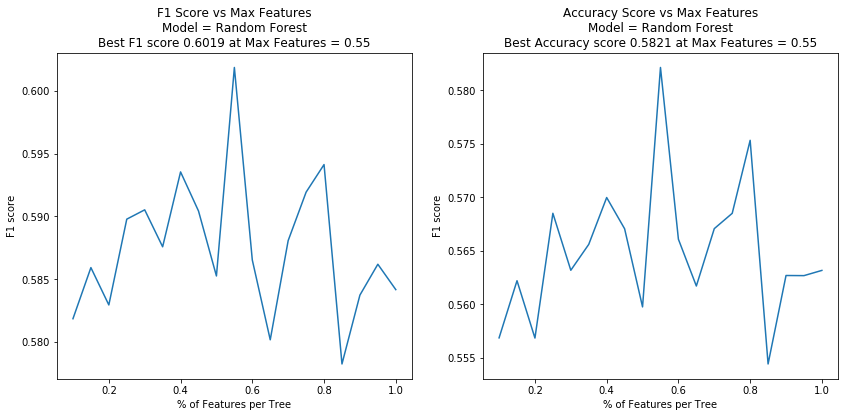

In [21]:
max_feature_range = np.arange(.1,1.05,.05)
kf = KFold(n_splits=5, shuffle=True, random_state = random_state)

f1_scores_list = []
acc_scores_list = []

for i in max_feature_range:
    rf = RandomForestClassifier(n_estimators=100,max_features=i,random_state=random_state)
    f1_scores_list.append(np.mean(cross_val_score(rf, X_train, y_train, cv=kf, scoring='f1')))
    acc_scores_list.append(np.mean(cross_val_score(rf, X_train, y_train, cv=kf, scoring='accuracy')))

best_f1 = np.max(f1_scores_list) 
best_f1_features = max_feature_range[np.argmax(f1_scores_list)]
    
best_acc = np.max(acc_scores_list) 
best_acc_features = max_feature_range[np.argmax(acc_scores_list)]  

plt.figure(figsize=(14,6))

plt.subplot(1, 2, 1)
sns.lineplot(x=max_feature_range,y=f1_scores_list)
plt.title('F1 Score vs Max Features\nModel = Random Forest\nBest F1 score %.4f at Max Features = %.2f' %
          (best_f1, best_f1_features))
plt.xlabel('% of Features per Tree')
plt.ylabel('F1 score')


plt.subplot(1, 2, 2)
sns.lineplot(x=max_feature_range,y=acc_scores_list)
plt.title('Accuracy Score vs Max Features\nModel = Random Forest\nBest Accuracy score %.4f at Max Features = %.2f' %
          (best_acc, best_acc_features))
plt.xlabel('% of Features per Tree')
plt.ylabel('F1 score');

In [31]:
rf = RandomForestClassifier(n_estimators=100,max_features=.55,random_state=random_state)
kf = KFold(n_splits=5, shuffle=True, random_state = random_state)

print ('Cross Validation Scores')
print('F1:  %.4f' % np.mean(cross_val_score(rf, X_train, y_train, cv=kf, scoring='f1')))
print('Accuracy:  %.4f' % np.mean(cross_val_score(rf, X_train, y_train, cv=kf, scoring='accuracy')))

Cross Validation Scores
F1:  0.6019
Accuracy:  0.5821


In [32]:
rf.fit(X_train, y_train)
y_pred = rf.predict(X_val)

print ('Out of Sample Scores (Validation Data)')
print('F1:  %.4f' % f1_score(y_val, y_pred))
print('Accuracy:  %.4f' % accuracy_score(y_val, y_pred))

Out of Sample Scores (Validation Data)
F1:  0.5580
Accuracy:  0.5335


In [34]:
y_pred = rf.predict(X_holdout)

print ('Holdout Data - Save for final analysis')
print('F1:  %.4f' % f1_score(y_holdout, y_pred))
print('Accuracy:  %.4f' % accuracy_score(y_holdout, y_pred))

Holdout Data - Save for final analysis
F1:  0.5997
Accuracy:  0.5648


<a id='7'></a>
# Predictive Models:  1 Month Stock Volatility

In [35]:
temp_df = price_df.copy()
# less_five = temp_df[abs(temp_df['p1_delta']) < 5].index
# temp_df = temp_df.drop(less_five)


X = temp_df[q_cols + a_cols + ['sector']]
X = pd.get_dummies(X)
y = (abs(temp_df['p1_delta']) > 4) * 1
random_state = 2019

# df = pd.get_dummies(df)

X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=0.2, random_state=random_state)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=random_state)


print ('1 Month Stock Price Change:')
print ('Price Change > 4%:  {:.4f}'.format(y.value_counts(normalize=True)[0]))
print ('Price Change < 4%:  {:.4f}'.format(y.value_counts(normalize=True)[1]))
print ('-----------------------------')
print ('Observation Sizes:')
print ('Train Observations: {}\nValidation Observations: {}\nHoldout Observations: {}'.format(X_train.shape[0], X_val.shape[0], X_holdout.shape[0]))

1 Month Stock Price Change:
Price Change > 4%:  0.5838
Price Change < 4%:  0.4162
-----------------------------
Observation Sizes:
Train Observations: 5800
Validation Observations: 1934
Holdout Observations: 1934


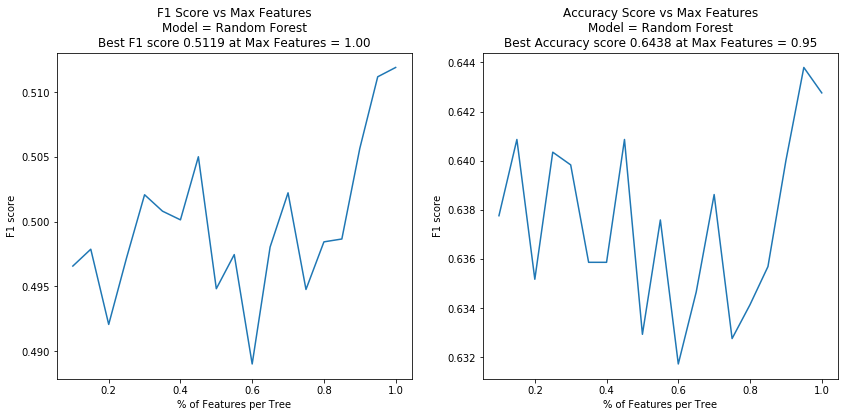

In [25]:
max_feature_range = np.arange(.1,1.05,.05)
kf = KFold(n_splits=5, shuffle=True, random_state = random_state)

f1_scores_list = []
acc_scores_list = []

for i in max_feature_range:
    rf = RandomForestClassifier(n_estimators=100,max_features=i,random_state=random_state)
    f1_scores_list.append(np.mean(cross_val_score(rf, X_train, y_train, cv=kf, scoring='f1')))
    acc_scores_list.append(np.mean(cross_val_score(rf, X_train, y_train, cv=kf, scoring='accuracy')))

best_f1 = np.max(f1_scores_list) 
best_f1_features = max_feature_range[np.argmax(f1_scores_list)]
    
best_acc = np.max(acc_scores_list) 
best_acc_features = max_feature_range[np.argmax(acc_scores_list)]  

plt.figure(figsize=(14,6))

plt.subplot(1, 2, 1)
sns.lineplot(x=max_feature_range,y=f1_scores_list)
plt.title('F1 Score vs Max Features\nModel = Random Forest\nBest F1 score %.4f at Max Features = %.2f' %
          (best_f1, best_f1_features))
plt.xlabel('% of Features per Tree')
plt.ylabel('F1 score')


plt.subplot(1, 2, 2)
sns.lineplot(x=max_feature_range,y=acc_scores_list)
plt.title('Accuracy Score vs Max Features\nModel = Random Forest\nBest Accuracy score %.4f at Max Features = %.2f' %
          (best_acc, best_acc_features))
plt.xlabel('% of Features per Tree')
plt.ylabel('F1 score');

In [36]:
rf = RandomForestClassifier(n_estimators=100,max_features=.95,random_state=random_state)
kf = KFold(n_splits=5, shuffle=True, random_state = random_state)

print ('Cross Validation Scores')
print('F1:  %.4f' % np.mean(cross_val_score(rf, X_train, y_train, cv=kf, scoring='f1')))
print('Accuracy:  %.4f' % np.mean(cross_val_score(rf, X_train, y_train, cv=kf, scoring='accuracy')))

Cross Validation Scores
F1:  0.5112
Accuracy:  0.6438


In [37]:
rf.fit(X_train, y_train)
y_pred = rf.predict(X_val)

print ('Out of Sample Scores (Validation Data)')
print('F1:  %.4f' % f1_score(y_val, y_pred))
print('Accuracy:  %.4f' % accuracy_score(y_val, y_pred))

Out of Sample Scores (Validation Data)
F1:  0.5028
Accuracy:  0.6360


In [38]:
y_pred = rf.predict(X_holdout)

print ('Holdout Data - Save for final analysis')
print('F1:  %.4f' % f1_score(y_holdout, y_pred))
print('Accuracy:  %.4f' % accuracy_score(y_holdout, y_pred))

Holdout Data - Save for final analysis
F1:  0.5299
Accuracy:  0.6422


<a id='8'></a>
# Tableau Data:  Company Sectors by Topics

In [39]:
# Output files for Tableau
q_topics.to_csv(out_path+'question_topics.csv')
a_topics.to_csv(out_path+'answers_topics.csv')

<a id='9'></a>
# Tableau Data:  Earning Call by Topics

In [40]:
price_df['p1_ret'] = price_df['p1_delta'] - price_df['bench_p1_delta_adj']
tableau_df_q = price_df[['call_id','sector','p1_ret']+q_cols].copy()
tableau_df_a = price_df[['call_id','sector','p1_ret']+a_cols].copy()

In [41]:
# Output files for Tableau
tableau_df_q.to_csv(out_path+'questions_calls.csv')
tableau_df_a.to_csv(out_path+'answers_calls.csv')